# Data Preprocessing

This is the same as the other `preprocess_data` notebook, however, this one attempts to get rid of the stop words that may be good indicators for low-tiered star classification. Being that there is a low accuracy with classifying low-tiered stars, a custom stop-word list can be a potential solution to increasing this accuracy. This notebook produces the vectorization of the tokenized `reviewText` column that is used as input for the different modeling. The vectorization process also utilizes `Word2Vec` (which has not been used previously) and `Doc2Vec` modeling to produce the desired matrices.

## Extract data into pandas dataframe

Ensure that the `AMAZON_FASHION.json.gz` file has been downloaded and copied into this directory. See `README.md` for more information.

In [1]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  df = {}
  for i, d in enumerate(parse(path)):
    df[i] = d
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('../../data/raw/AMAZON_FASHION.json.gz')

In [2]:
# Remove duplicate reviews
# Any review with the same reviewText, reviewerID, overall ranking is considered a duplicate
df = df.drop_duplicates(subset=['reviewText', 'reviewerID', 'overall'])

# Keep relevant columns
df = df[['reviewText', 'overall']]

# Drop reviews with no reviewText since we are primarily interested in analyzing review text
df = df.dropna(subset=['reviewText'])

df.head()

,reviewText,overall
0,Exactly what I needed.,5.0
1,"I agree with the other review, the opening is ...",2.0
2,Love these... I am going to order another pack...,4.0
3,too tiny an opening,2.0
4,Okay,3.0


In [3]:
# Check for NaN values in each column
nan_columns = df.isna().any()
print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
reviewText    False
overall       False
dtype: bool


## EDA

Distribution of star ratings

Text(0, 0.5, 'Number of Reviews')

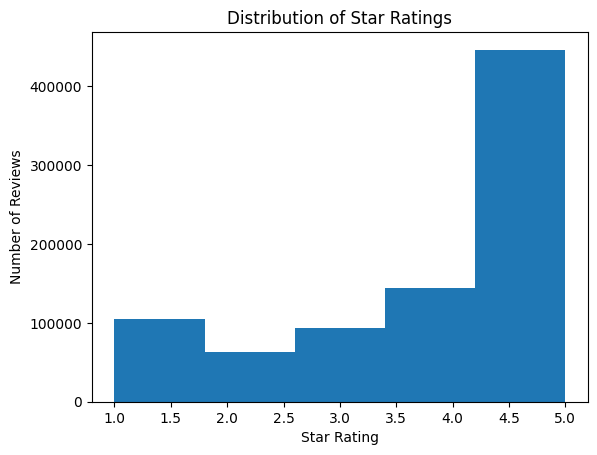

In [4]:
import matplotlib.pyplot as plt
plt.hist(df['overall'], bins=5)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')

Star ratings skew left with a clear peak for 5 stars. To avoid bias, we could consider sampling to achieve more equally distributed training data.

In [5]:
df['reviewTextLength'] = df['reviewText'].str.len()
print(df['reviewTextLength'].describe())

count    851740.000000
mean        147.683403
std         202.048854
min           1.000000
25%          36.000000
50%          88.000000
75%         180.000000
max       10565.000000
Name: reviewTextLength, dtype: float64


reviewTextLength
1         154
2        1739
3         594
4        7743
5        4941
         ... 
6543        1
6688        1
7398        1
9461        1
10565       1
Name: count, Length: 2582, dtype: int64


(0.0, 10000.0)

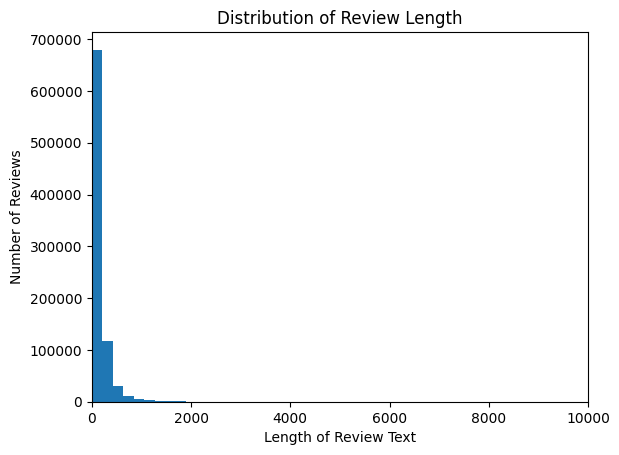

In [6]:
# look at distribution of reviewTextLength
print(df['reviewTextLength'].value_counts().sort_index())
plt.hist(df['reviewTextLength'], bins=50)
plt.title('Distribution of Review Length')
plt.xlabel('Length of Review Text')
plt.ylabel('Number of Reviews')
plt.xlim(0, 10000)

This shows that review length skews right with many large outliers.

## Tokenization

In [7]:
# sample 50,000 reviews
df = df.sample(50000, random_state=42)

In [8]:
from nltk import word_tokenize
from collections import Counter

# Tokenize the reviewText column
all_words = []
for review in df['reviewText']:
    words = word_tokenize(review.lower())
    all_words.extend(words)

# Count the frequency of each word
word_counts = Counter(all_words)

# Determine the most common words
most_common_words = word_counts.most_common()


In [9]:
# Print the most common words
for word, frequency in most_common_words[:40]:
    print(f'{word}: {frequency}')

.: 96465
the: 63452
i: 58544
it: 49321
and: 43583
a: 40454
,: 40374
to: 28220
is: 25020
!: 24483
for: 20514
this: 19373
my: 18071
but: 16417
was: 15059
of: 14946
in: 14808
not: 12636
very: 12486
on: 11182
that: 10781
they: 10505
n't: 10237
so: 10143
are: 9682
with: 9506
as: 9195
great: 8847
have: 8643
's: 8636
love: 8475
like: 8372
fit: 8146
you: 7953
size: 7829
them: 6920
these: 6817
be: 6554
small: 6535
too: 6241


In [10]:
top_40_words = [word for word, _ in most_common_words[:40]]
print(top_40_words)


['.', 'the', 'i', 'it', 'and', 'a', ',', 'to', 'is', '!', 'for', 'this', 'my', 'but', 'was', 'of', 'in', 'not', 'very', 'on', 'that', 'they', "n't", 'so', 'are', 'with', 'as', 'great', 'have', "'s", 'love', 'like', 'fit', 'you', 'size', 'them', 'these', 'be', 'small', 'too']


In [11]:
# Words to remove that are good indicating words
words_to_remove = ['not', 'very', "n't", 'love', 'great', 'like', 'fit', 'small', 'but', 'size']

# Filter out the words to remove
filtered_top_40_words = [word for word in top_40_words if word not in words_to_remove]

# Print the filtered list
print(filtered_top_40_words)


['.', 'the', 'i', 'it', 'and', 'a', ',', 'to', 'is', '!', 'for', 'this', 'my', 'was', 'of', 'in', 'on', 'that', 'they', 'so', 'are', 'with', 'as', 'have', "'s", 'you', 'them', 'these', 'be', 'too']


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')

stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()

# Function to tokenize, stem, and lemmatize the review text
def tokenize_stem_review(review, stopwords):
    tokens = nltk.word_tokenize(review)
    tokens = [t.lower() for t in tokens if t.lower() not in stopwords]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply tokenization and stemming to each review text and using filtered top_40_words
df['reviewTokens'] = df.apply(lambda row: tokenize_stem_review(row['reviewText'], filtered_top_40_words), axis=1)

df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucym\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviewText,overall,reviewTextLength,reviewTokens
667904,I was pleasantly surprised that these are slig...,4.0,170,"[pleasantli, surpris, slightli, decent, qualit..."
264104,Great lightweight skirt that pairs well with p...,5.0,108,"[great, lightweight, skirt, pair, well, pretti..."
693418,Does not look like the picture at all - nice m...,1.0,78,"[doe, not, look, like, pictur, at, all, -, nic..."
466010,for my size this is a very comfortable suit- I...,4.0,280,"[size, veri, comfort, suit-, am, glad, ha, cup..."
774815,"Love, love, love!!!!!!",5.0,22,"[love, love, love]"


In [14]:
# Save the new DataFrame as CSV
new_csv_file_path = '../../data/processed/tokenized_data_sample_with_custom_stopwords.csv'

df.to_csv(new_csv_file_path)

# Confirm the CSV file has been saved
print(f"CSV file saved as '{new_csv_file_path}'")


CSV file saved as '../../data/processed/tokenized_data_sample_with_custom_stopwords.csv'


## Vectorizing Textual Features

In [19]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

tokenized_data = pd.read_csv('../../data/processed/tokenized_data_sample_with_custom_stopwords.csv')['reviewTokens']

# Train the Word2Vec model
vec_size = 100  # Dimensionality of the word vectors
window = 5  # Maximum distance between the current and predicted word within a sentence
min_count = 1  # Minimum frequency of a word to be considered for training
workers = 4  # Number of threads to use while training

model = Word2Vec(sentences=tokenized_data, vector_size=vec_size, window=window, min_count=min_count, workers=workers)


word_vectors = []

# Iterate through each tokenized sentence or document and retrieve word vectors
for tokens in tokenized_data:
    word_vectors.append(np.mean([model.wv[token] if token in model.wv else np.zeroes(vec_size) for token in tokens], axis=0))

# Convert the list of word vectors into a NumPy array
vectorized_features_with_custom_stopwords_word2vec = np.array(word_vectors)

In [20]:
len(vectorized_features_with_custom_stopwords_word2vec)

50000

In [21]:
import numpy as np
np.save('../../data/processed/sample_vectorized_features_with_custom_stopwords_word2vec.npy', vectorized_features_with_custom_stopwords_word2vec)
